In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from neo4j import GraphDatabase
from scipy.stats import zscore

In [37]:
URI = "bolt://localhost:7687"  # Update if running remotely
USERNAME = "neo4j"
PASSWORD = "password"  # Replace with your Neo4j password

# Connect to Neo4j
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

In [38]:
def load_csv_data(file_path):
    """Load FX trade data from a CSV file"""
    df = pd.read_csv(file_path)
    return df

In [39]:
def create_graph_relationships(driver, df):
    """Create relationships between trades in Neo4j"""
    with driver.session() as session:
        for i in range(len(df) - 1):
            session.run("""
                MATCH (t1:Trade {trade_id: $trade1_id}), (t2:Trade {trade_id: $trade2_id})
                MERGE (t1)-[:NEXT_TRADE]->(t2)
            """, trade1_id=df.iloc[i]["trade_id"], trade2_id=df.iloc[i + 1]["trade_id"])

        for i in range(len(df)):
            for j in range(i + 1, len(df)):
                if abs(df.iloc[i]["price"] - df.iloc[j]["price"]) < 0.002 and abs(df.iloc[i]["volume"] - df.iloc[j]["volume"]) < 10000:
                    session.run("""
                        MATCH (t1:Trade {trade_id: $trade1_id}), (t2:Trade {trade_id: $trade2_id})
                        MERGE (t1)-[:SIMILAR_TRADE]->(t2)
                    """, trade1_id=df.iloc[i]["trade_id"], trade2_id=df.iloc[j]["trade_id"])

In [40]:
def detect_outliers(df):
    """Identify outliers using Z-score and IQR"""
    df["zscore_price"] = np.abs(zscore(df["price"]))
    df["zscore_volume"] = np.abs(zscore(df["volume"]))

    # Z-score threshold (commonly 3)
    df["outlier_z"] = (df["zscore_price"] > 3) | (df["zscore_volume"] > 3)

    # IQR method
    Q1_price, Q3_price = df["price"].quantile([0.25, 0.75])
    IQR_price = Q3_price - Q1_price
    df["outlier_iqr"] = (df["price"] < (Q1_price - 1.5 * IQR_price)) | (df["price"] > (Q3_price + 1.5 * IQR_price))

    df["outlier"] = df["outlier_z"] | df["outlier_iqr"]
    return df

In [41]:
def mark_outliers_in_neo4j(driver, df):
    """Mark detected outliers in Neo4j"""
    with driver.session() as session:
        for _, row in df.iterrows():
            if row["outlier"]:
                session.run("""
                    MATCH (t:Trade {trade_id: $trade_id})
                    SET t.outlier = true
                """, trade_id=row["trade_id"])

In [42]:
def visualize_trades(df):
    """Visualize trades and highlight outliers using Plotly"""
    fig = px.scatter(df, x="trade_time", y="price", color=df["outlier"].map({True: 'Outlier', False: 'Normal'}),
                     title="Trade Price Analysis", hover_data=["trade_id", "currency_pair", "volume"])
    fig.show()

In [43]:
import pandas as pd

data = {
    "trade_id": [1, 2, 3, 4, 5],
    "currency_pair": ["EUR/USD", "GBP/USD", "USD/JPY", "EUR/USD", "GBP/USD"],
    "trade_time": ["2024-02-19 10:00:00", "2024-02-19 10:05:00", "2024-02-19 10:10:00", "2024-02-19 10:15:00", "2024-02-19 10:20:00"],
    "price": [1.0850, 1.2650, 150.25, 1.0865, 1.2635],
    "volume": [100000, 50000, 200000, 75000, 60000]
}

df = pd.DataFrame(data)
df.to_csv("fx_trades.csv", index=False)

print("fx_trades.csv has been created!")


fx_trades.csv has been created!


In [44]:
def store_trades_in_neo4j(driver, df):
    """Store trade data in Neo4j as nodes"""
    with driver.session() as session:
        for _, row in df.iterrows():
            # Convert trade_time to Neo4j-compatible format
            trade_time_iso = pd.to_datetime(row['trade_time']).isoformat()

            session.run("""
                MERGE (t:Trade {trade_id: $trade_id})
                SET t.currency_pair = $currency_pair,
                    t.trade_time = datetime($trade_time),
                    t.price = $price,
                    t.volume = $volume
            """, 
            trade_id=int(row['trade_id']),
            currency_pair=row['currency_pair'],
            trade_time=trade_time_iso,  # Converted to ISO format
            price=float(row['price']),
            volume=int(row['volume'])
            )


In [45]:
def main():
    file_path = "fx_trades.csv"  # Update file path

    # Load and process data
    df = load_csv_data(file_path)
    
    # Store data in Neo4j
    store_trades_in_neo4j(driver, df)
    
    # Construct Graph
    create_graph_relationships(driver, df)
    
    # Detect outliers
    df = detect_outliers(df)
    
    # Mark outliers in Neo4j
    mark_outliers_in_neo4j(driver, df)
    visualize_trades(df)

    print("Stock Trade Outlier Analysis completed!")

if __name__ == "__main__":
    main()

Stock Trade Outlier Analysis completed!


In [46]:
import pandas as pd
import numpy as np

def detect_outliers(df):
    """Detect outliers in trade price and volume using IQR"""
    
    outliers = {}  # Store outlier details
    
    for column in ['price', 'volume']:  
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find outliers
        outlier_values = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers[column] = outlier_values

    return outliers

# Load trade data (example CSV file)
df = pd.read_csv("fx_trades.csv")

# Detect outliers
outlier_results = detect_outliers(df)

# Print detected outliers
for column, outliers in outlier_results.items():
    print(f"\n🔹 Outliers in {column}:")
    print(outliers[['trade_id', 'currency_pair', 'trade_time', column]])



🔹 Outliers in price:
   trade_id currency_pair           trade_time   price
2         3       USD/JPY  2024-02-19 10:10:00  150.25

🔹 Outliers in volume:
   trade_id currency_pair           trade_time  volume
2         3       USD/JPY  2024-02-19 10:10:00  200000


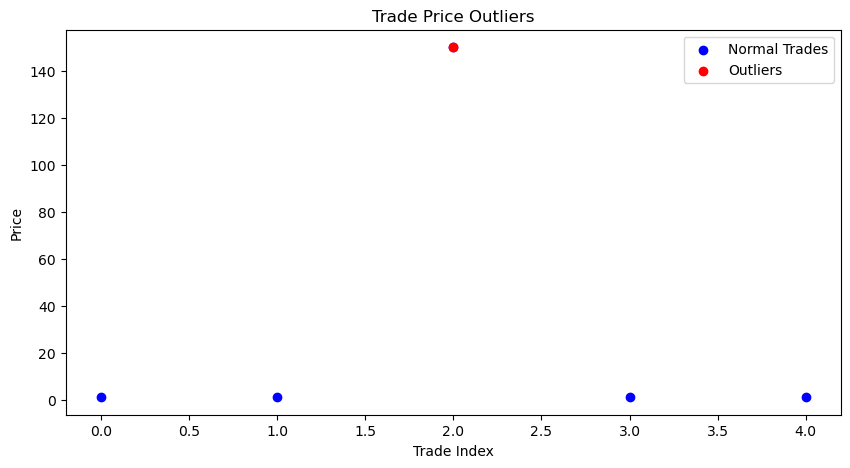

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['price'], label='Normal Trades', color='blue')
plt.scatter(outlier_results['price'].index, outlier_results['price']['price'], label='Outliers', color='red')
plt.xlabel("Trade Index")
plt.ylabel("Price")
plt.title("Trade Price Outliers")
plt.legend()
plt.show()


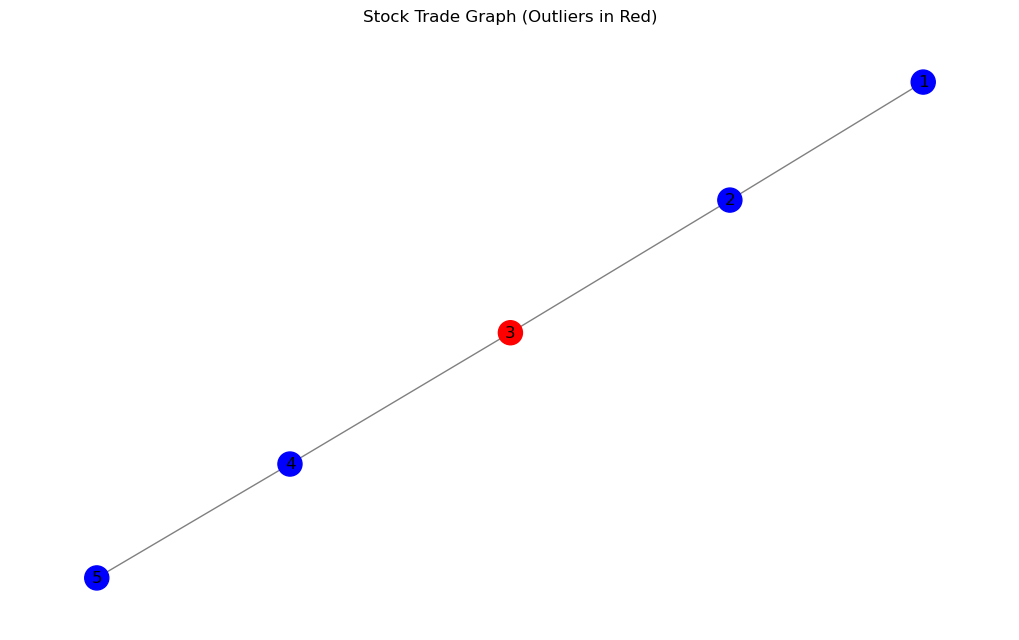

In [48]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def create_trade_graph(df, outliers_df):
    """Create a NetworkX graph with trades as nodes and relationships as edges"""
    G = nx.Graph()
    
    # Add nodes (trades)
    for _, row in df.iterrows():
        G.add_node(row['trade_id'], 
                   currency_pair=row['currency_pair'], 
                   price=row['price'], 
                   volume=row['volume'],
                   is_outlier=row['trade_id'] in outliers_df['trade_id'].values)

    # Add edges (connect consecutive trades)
    for i in range(len(df) - 1):
        G.add_edge(df.iloc[i]['trade_id'], df.iloc[i+1]['trade_id'])

    return G

# Load trade data
df = pd.read_csv("fx_trades.csv")

# Detect outliers
outliers = detect_outliers(df)
outliers_df = pd.concat(outliers.values())  # Combine price & volume outliers

# Create graph
trade_graph = create_trade_graph(df, outliers_df)

# Draw graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(trade_graph)  # Position nodes

# Color nodes (Red for outliers, Blue for normal trades)
node_colors = ['red' if trade_graph.nodes[n]['is_outlier'] else 'blue' for n in trade_graph.nodes]

nx.draw(trade_graph, pos, with_labels=True, node_color=node_colors, node_size=300, edge_color="gray")
plt.title("Stock Trade Graph (Outliers in Red)")
plt.show()


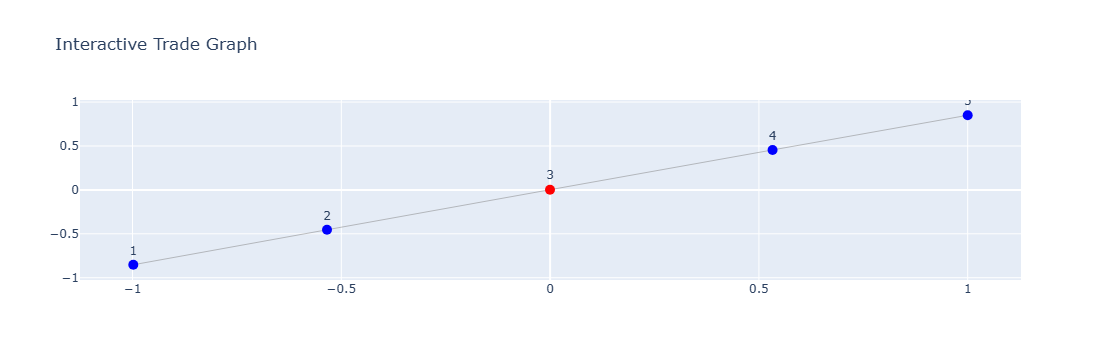

In [49]:
import plotly.graph_objects as go

def plot_interactive_graph(G):
    """Visualize the trade graph using Plotly"""
    edge_x, edge_y = [], []
    node_x, node_y, node_color = [], [], []

    pos = nx.spring_layout(G)  # Layout

    # Add edges
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Add nodes
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append('red' if G.nodes[node]['is_outlier'] else 'blue')

    # Create figure
    fig = go.Figure()

    # Draw edges
    fig.add_trace(go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='gray'), mode='lines'))

    # Draw nodes
    fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers+text',
                             marker=dict(size=10, color=node_color), text=list(G.nodes()), textposition="top center"))

    fig.update_layout(title="Interactive Trade Graph", showlegend=False)
    fig.show()

# Plot interactive graph
plot_interactive_graph(trade_graph)


In [50]:
def generate_report(df, outliers):
    """Generate a summary report of trade anomalies"""
    total_trades = len(df)
    outlier_count = {col: len(outliers[col]) for col in outliers}
    
    report = f"""
    Stock Trade Outlier Analysis Report
    -----------------------------------
    Total Trades Analyzed: {total_trades}
    
    Outlier Summary:
    - Price Outliers: {outlier_count.get('price', 0)}
    - Volume Outliers: {outlier_count.get('volume', 0)}
    
    Recommendations:
    - Investigate price anomalies for potential market manipulation.
    - Review high-volume trades for unusual activity.
    - Compare with expected trade patterns to detect deviations.
    """
    
    with open("trade_analysis_report.txt", "w") as file:
        file.write(report)

    print(report)

# Generate report
generate_report(df, outliers)



    Stock Trade Outlier Analysis Report
    -----------------------------------
    Total Trades Analyzed: 5
    
    Outlier Summary:
    - Price Outliers: 1
    - Volume Outliers: 1
    
    Recommendations:
    - Investigate price anomalies for potential market manipulation.
    - Review high-volume trades for unusual activity.
    - Compare with expected trade patterns to detect deviations.
    
